# Pre-process data
SID: 510138903 
Name: Yichen Chen

## Preparations

In [1]:
import h5py
import numpy as np
import os
import datetime
import time

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

print(os.listdir("./Input/train/"))

['images_training.h5', 'labels_training.h5']


## Define time calculator
Define a function which can receive three arguments, time difference between two time.perf_counter() is the time cost.

In [2]:
def calculate_time(start,finish,stmt):
    print("The time consumed by {} is {:.10f} s!".format(stmt,(finish - start)))
    return finish-start
# start is when the timer start
Start = time.perf_counter()
# then stop
Finish = time.perf_counter()

## Load data

In [3]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

print(data_train.shape,label_train.shape)
print(data_test.shape,label_test.shape)

(30000, 784) (30000,)
(5000, 784) (2000,)


Showing a sample data. The first example belongs to class 0: T-Shirt/Top

Now the shape of the data is  (30000, 784)

  |1 Shirt| |2 T-shirt/Top| |3 Trouser| |4 Pullover| |5 Ankle boot| |6 Sandal| |7 Ankle boot| |8 Sneaker| |9 Shirt| 


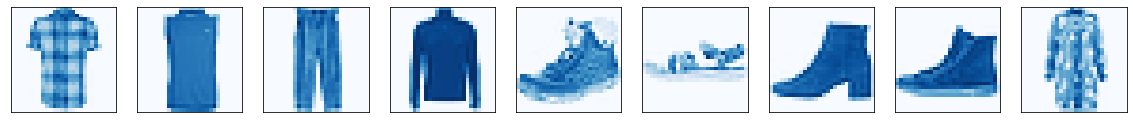

In [4]:
import matplotlib.pyplot as plt

sample_name = {"0":"T-shirt/Top",
"1":"Trouser",
"2":"Pullover",
"3":"Dress",
"4":"Coat",
"5":"Sandal",
"6":"Shirt",
"7":"Sneaker",
"8":"Bag",
"9":"Ankle boot"}

# reshape for print images
data_train_images = data_train.reshape((data_train.shape[0], 28, 28))

# reshape from 28x28 back to 784
data_train = data_train.reshape((data_train.shape[0], 784))
print("Now the shape of the data is ",data_train.shape)

# establish background, print images, “num” is how many images you want to show

num = 9
back, position = plt.subplots(1,num,
                              figsize = (20,2),
                              subplot_kw = {"xticks":[],"yticks":[]}
                             )
tem = ""
for i in range(num):
    position[i].imshow(data_train_images[i], cmap=plt.get_cmap('Blues'))
    tem += "|"+str(i+1)+" "+sample_name[str(label_train[i])]+"| "
    
print("\n  "+tem)

## PCA


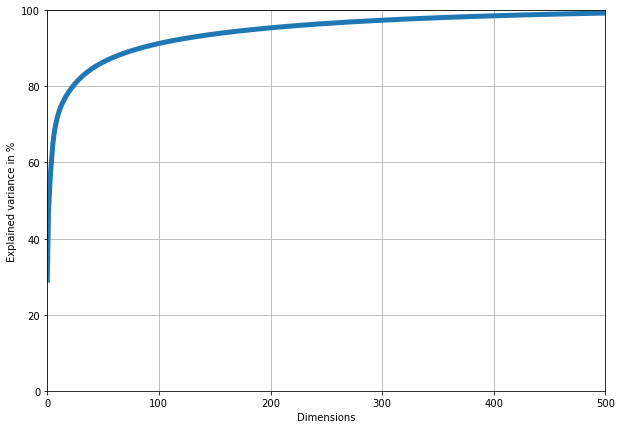

The shape of reduced data train is 30000, the dimension is 150.
The shape of reduced data test is 5000, the dimension is 150.

The time consumed by PCA is 2.1141949000 s!


In [5]:
Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

# PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# show line chart to find appropriate n
pca = PCA().fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize = (10,7))
plt.plot(cumsum*100, linewidth=5)
plt.axis([0, 500, 0, 100]) 
plt.xlabel("Dimensions")
plt.ylabel("Explained variance in %")
plt.grid()
plt.show()

# Choose 150 components which can retain close to 95% variance
pca=PCA(n_components=150)

data_train_reduced = pca.fit_transform(data_train)
data_test_reduced = pca.transform(data_test)

print("The shape of reduced data train is {}, the dimension is {}.".format(data_train_reduced.shape[0],data_train_reduced.shape[1]))
print("The shape of reduced data test is {}, the dimension is {}.\n".format(data_test_reduced.shape[0],data_test_reduced.shape[1]))


# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()

timePreprocessing = calculate_time(Start,Finish,"PCA")

In [6]:
from sklearn.model_selection import GridSearchCV

def get_eval(model, para):
    
    grid = GridSearchCV(model, para, cv=10,
                          return_train_score=True, n_jobs= -1,verbose=2)
    grid.fit(data_train_reduced, label_train)
    
    return grid

# This is a function can return the fitted model before gridsearch CV

In [7]:
def print_eval(final_model):
    
    y_pred = final_model.predict(data_test_reduced)
    print("Test set accuracy: {:.2f}".format(accuracy_score(label_test, y_pred[0:2000])))
    
   
    print("Training set accuracy: {:.2f}\n".format(final_model.score(data_train_reduced, label_train)))
    
    print("The Best cross-validation : {}, score: {:.2f}".format(final_model.best_estimator_, final_model.best_score_))
    
# This is a function can print the test score and training score, also the best CV score and best hyper-parameters.

# Tuning hyper-parameters


## Tuning svm hyper-parameters

In [50]:
# =======================================================================================================================
# Tuning SVM ============================================================================================================
# =======================================================================================================================

Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

from sklearn.svm import SVC

parameters_svm = {'kernel' : ["rbf"], "C" : [5,12,20],"gamma":[0.0015,0.015,0.15]}
SVM_GAUSSIAN = get_eval(SVC(),parameters_svm)
print_eval(SVM_GAUSSIAN)

# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
timeTuningSVM = calculate_time(Start,Finish,"TuningSVM")

# The tuning process of SVM, parameters_svm is the hyper-parameters waiting for tuning.Same below

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 45.7min finished


Test set accuracy: 0.89
Training set accuracy: 0.97

The Best cross-validation : SVC(C=12, gamma=0.015), score: 0.90
The time consumed by TuningSVM is 2828.7787594000 s!


## Tuning NaiveBayes hyper-parameters

In [38]:
# =======================================================================================================================
# Tuning NaiveBayes =====================================================================================================
# =======================================================================================================================

Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

from sklearn.naive_bayes import GaussianNB

parameters_gnb = {"var_smoothing":[1e-1000,1e-100,1e-20,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6]}
gnb = get_eval(GaussianNB(),parameters_gnb)
print_eval(gnb)

# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()

timeTuningSVM = calculate_time(Start,Finish,"TuningNaiveBayes")

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.5s finished


Test set accuracy: 0.74
Training set accuracy: 0.76

The Best cross-validation : GaussianNB(var_smoothing=0.0), score: 0.75
The time consumed by TuningNaiveBayes is 18.1970863000 s!


## Tuning KNN hyper-parameters

In [16]:
# =======================================================================================================================
# Tuning KNN ============================================================================================================
# =======================================================================================================================

Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------



from sklearn.neighbors import KNeighborsClassifier

parameters_knn = {'n_neighbors': [1,5,7,10,15]}
knn = get_eval(KNeighborsClassifier(), parameters_knn)
print_eval(knn)

# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()

timeTuningSVM = calculate_time(Start,Finish,"TuningNaiveBayes")

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.1min finished


Test set accuracy: 0.84
Training set accuracy: 0.89

The Best cross-validation : KNeighborsClassifier(n_neighbors=7), score: 0.86
The time consumed by TuningNaiveBayes is 490.5862708000 s!


## Tuning Decision Tree hyper-parameters

In [89]:
# =======================================================================================================================
# Tuning DecisionTree ===================================================================================================
# =======================================================================================================================

Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

from sklearn.tree import DecisionTreeClassifier

parameters_DTC = {"criterion":["gini","entropy"],"max_depth":[1,5,10,20,50,100],"splitter":["best","random"]}
DTC = get_eval(DecisionTreeClassifier(),parameters_DTC)
print_eval(DTC)

# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.0min finished


Test set accuracy: 0.78
Training set accuracy: 0.84

The Best cross-validation : DecisionTreeClassifier(criterion='entropy', max_depth=10), score: 0.77
The time consumed by TuningDecisionTree is 134.6664998000 s!


# Model training and testing

## DecisionTree training and testing

In [51]:
# =======================================================================================================================
# Training,Testing DecisionTree =========================================================================================
# =======================================================================================================================
from sklearn.tree import DecisionTreeClassifier
Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

DT = DecisionTreeClassifier(criterion = "entropy",max_depth = 10)
model_DT = DT.fit(data_train_reduced, label_train)

print("Training set Accuracy")
print(model_DT.score(data_train_reduced,label_train))
print("Test set Accuracy")
print(model_DT.score(data_test_reduced[0:2000],label_test))


# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
Time_TrainTestDT = calculate_time(Start,Finish,"Train,Test DecisionTree")

# These blocks can print :
# 1. Training score of one specific model
# 2. Test score of one specific model
# 3. Time consuming.
# Same below.

Training set Accuracy
0.8429
Test set Accuracy
0.773
The time consumed by Train,Test DecisionTree is 11.9459234000 s!


## KNN training and testing

In [52]:
# =======================================================================================================================
# Training,Testing KNN ==================================================================================================
# =======================================================================================================================
from sklearn.neighbors import KNeighborsClassifier
Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

KNN = KNeighborsClassifier(p = 1,n_neighbors = 7)
model_KNN = KNN.fit(data_train_reduced, label_train)

print("Training set Accuracy")
print(model_KNN.score(data_train_reduced,label_train))
print("Test set Accuracy")
print(model_KNN.score(data_test_reduced[0:2000],label_test))


# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
Time_TrainTestKNN = calculate_time(Start,Finish,"Train,Test KNN")

Training set Accuracy
0.8909
Test set Accuracy
0.8405
The time consumed by Train,Test KNN is 254.4734934000 s!


## NaiveBayes training and testing

In [53]:
# =======================================================================================================================
# Training,Testing NaiveBayes ===========================================================================================
# =======================================================================================================================
from sklearn.naive_bayes import GaussianNB
Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

NB = GaussianNB(var_smoothing = 0)
model_NB = NB.fit(data_train_reduced, label_train)

print("Training set Accuracy")
print(model_NB.score(data_train_reduced,label_train))
print("Test set Accuracy")
print(model_NB.score(data_test_reduced[0:2000],label_test))


# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
Time_TrainTestNB = calculate_time(Start,Finish,"Train,Test NaiveBayes")

Training set Accuracy
0.7579666666666667
Test set Accuracy
0.737
The time consumed by Train,Test NaiveBayes is 0.4842840000 s!


## SVM training and testing

In [10]:
# =======================================================================================================================
# Training,Testing SVM ==================================================================================================
# =======================================================================================================================
from sklearn.svm import SVC
Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

SVM = SVC(kernel = "rbf",C = 12,gamma = 0.015)
model_SVM = SVM.fit(data_train_reduced, label_train)

print("Training set Accuracy")
print(model_SVM.score(data_train_reduced,label_train))
print("Test set Accuracy")
print(model_SVM.score(data_test_reduced[0:2000],label_test))


# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
Time_TrainTestSVM = calculate_time(Start,Finish,"Training,Testing SVM")

Training set Accuracy
0.9737333333333333
Test set Accuracy
0.8885
The time consumed by Training,Testing SVM is 82.7914306000 s!


In [11]:
print("The best model is SVM, C=12, gamma=0.015, with Training Accuracy 0.97 and Test Accuracy 0.89")
print("Time consuming 83 s")

The best model is SVM, C=12, gamma=0.015, with Training Accuracy 0.97 and Test Accuracy 0.89
Time consuming 83 s


# Comparison result between algorithms

## TrainScore and TestScore comparison

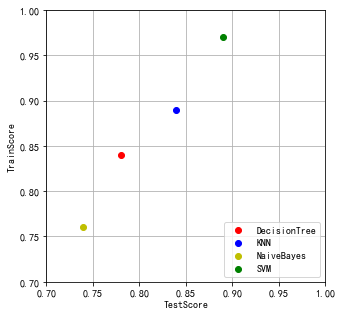

In [47]:
TimeList = [Time_TrainTestDT,Time_TrainTestKNN,Time_TrainTestNB,Time_TrainTestSVM]
TrainScore = [0.84,0.89,0.76,0.97]
TestScore = [0.77,0.84,0.74,0.89]
ModelName = ["DecisionTree","KNN","NaiveBayes","SVM"]

plt.figure(figsize = (5,5))
plt.scatter(TestScore[0],TrainScore[0],c="r",label = ModelName[0])
plt.scatter(TestScore[1],TrainScore[1],c="b",label = ModelName[1])
plt.scatter(TestScore[2],TrainScore[2],c="y",label = ModelName[2])
plt.scatter(TestScore[3],TrainScore[3],c="g",label = ModelName[3])
plt.legend(loc=4,ncol=1)
plt.axis([0.7,1,0.7,1]) 
plt.xlabel("TestScore")
plt.ylabel("TrainScore")
plt.grid()
plt.show()

# Show the plot of accuracy.

## Time consuming comparison

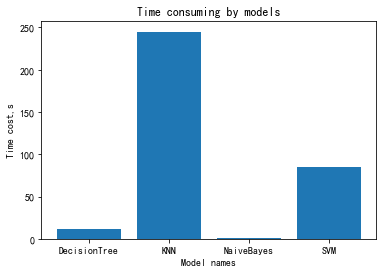

In [55]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.bar(ModelName, TimeList)
plt.title('Time consuming by models')
plt.xlabel("Model names")
plt.ylabel("Time cost,s")
plt.show()

# Show the time consuming histogram.

# Data output

In [56]:
with h5py.File('Output/predicted_labels.h5','w') as H:
    output = model_SVM.predict(data_test_reduced)
    H.create_dataset('Output',data=output)
    
print(output.shape)
print("\nFirst 10")
output[0:10]

# Output data and print first 10.

(5000,)

First 10


array([1, 8, 1, 8, 4, 0, 6, 5, 3, 1], dtype=uint8)

# More analysis for improvement and reflection

## Explore and compare the impact of data set size on accuracy for SVM and NaiveBayes

### Explore the impact of data set size on accuracy for SVM

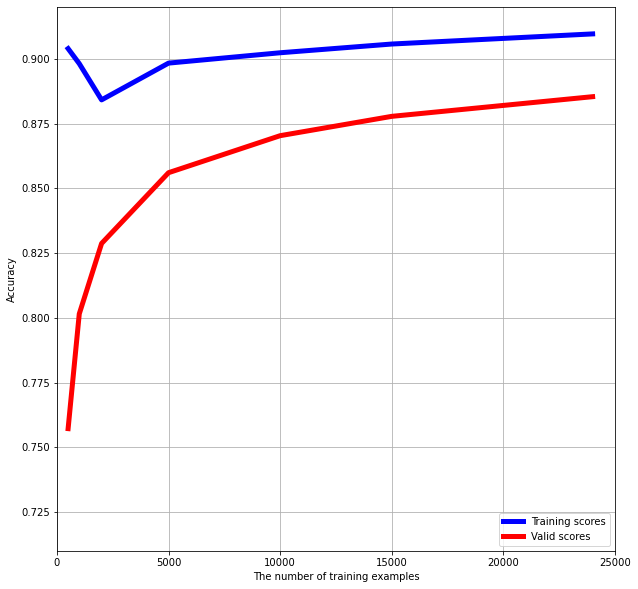

In [46]:
# SVM
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# Setting parameters for learning_curve
train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel='rbf'),data_train_reduced, label_train, train_sizes=[500, 1000, 2000,5000,10000,15000,24000], n_jobs= -1,cv=5)

# Store and calculate the mean performances of validation and training accuracy.
valid_scores1 = []
train_scores1 = []
for i in range(7):
    valid_scores1.append(np.mean(valid_scores[i]))
    train_scores1.append(np.mean(train_scores[i]))
    
plt.figure(figsize = (10,10))
plt.plot(train_sizes,train_scores1,"b",linewidth=5,label = "Training scores")
plt.plot(train_sizes,valid_scores1,"r",linewidth=5,label = "Valid scores")
plt.legend(loc=4,ncol=1)
plt.axis([0,25000,0.71,0.92]) 
plt.xlabel("The number of training examples")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

# Using learning curve to evaluate the impact of data set size on accuracy. Same below for Naive Bayes.

### Explore the impact of data set size on accuracy for NaiveBayes

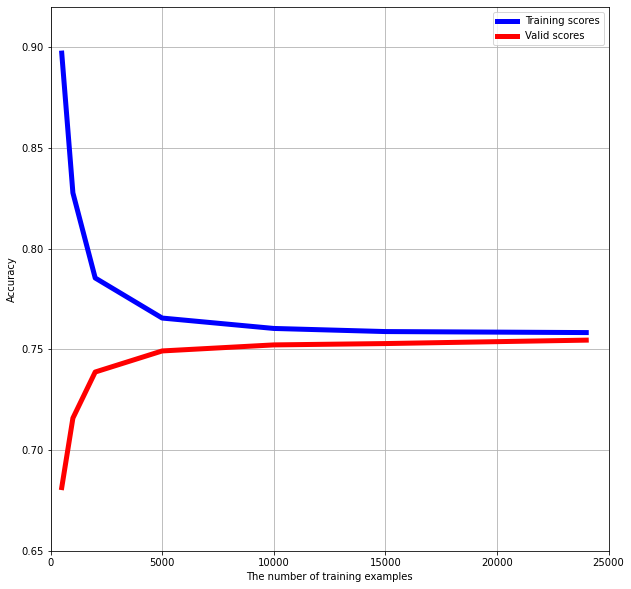

In [43]:
# naive bayes
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB

train_sizes, train_scores, valid_scores = learning_curve(GaussianNB(),data_train_reduced, label_train, train_sizes=[500, 1000, 2000,5000,10000,15000,24000], n_jobs= -1,cv=5)

valid_scores1 = []
train_scores1 = []
for i in range(7):
    valid_scores1.append(np.mean(valid_scores[i]))
    train_scores1.append(np.mean(train_scores[i]))
    
plt.figure(figsize = (10,10))
plt.plot(train_sizes,train_scores1,"b",linewidth=5,label = "Training scores")
plt.plot(train_sizes,valid_scores1,"r",linewidth=5,label = "Valid scores")
plt.legend(loc=1,ncol=1)
plt.axis([0,25000,0.65,0.92]) 
plt.xlabel("The number of training examples")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

## Analyzing hyper-parameters for SVM
Just clarify: I have already done GridSearch for SVM hyper-parameter tuning above.
The best hyperparameter from my hyper-parameter list has been selected above.
I do this for comparing how these unselected SVM hyper-parameter perform at accuracy by using graph for upcoming report.

### Analyze C

In [39]:
from sklearn.svm import SVC
def get_single_eval(model,para):
    grid = GridSearchCV(model, para, cv=3, n_jobs= -1,verbose=2)    
    model = grid.fit(data_train_reduced, label_train)
    # This part only run for comparing different hyper-parameters by plot, not for choosing best hyper-parameter, so I set cv = 3 to save time.
    return model.best_score_

AccuracyList = []
Hyper_parameters_list = [0.001,0.01,0.1,1,10,15,30,50,100,500,1000]
for i in range(11):
    paraC = Hyper_parameters_list[i]
    parameters_svm = {'kernel' : ["rbf"], "C" : [paraC],"gamma":["scale"]}
    AccuracyList.append(get_single_eval(SVC(),parameters_svm))
print(AccuracyList)

# Show specific process of tuning of SVM C parameter. Same below for gamma.

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.0s finished


[0.2561, 0.7487666666666666, 0.8334999999999999, 0.8817, 0.8932333333333333, 0.8926333333333333, 0.8898666666666667, 0.8883666666666666, 0.8858333333333333, 0.8852333333333333, 0.8852333333333333]


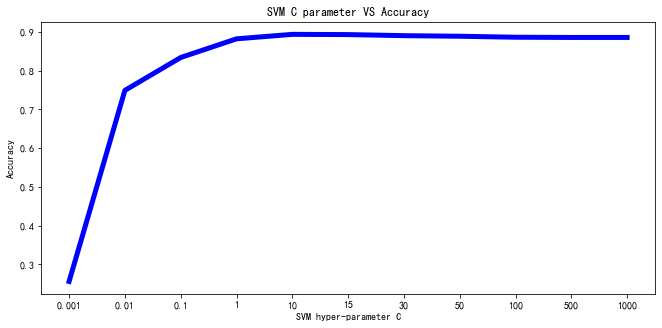

In [40]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize = (11,5))
plt.plot(["0.001","0.01","0.1","1","10","15","30","50","100","500","1000"],AccuracyList,"b",linewidth=5)
plt.xlabel("SVM hyper-parameter C")
plt.ylabel("Accuracy")
plt.title("SVM C parameter VS Accuracy")
plt.show()

### Analyze gamma

In [49]:
AccuracyList2 = []
Hyper_parameters_list = [10,1,0.1,0.01,0.0001,0.000001,0.00000001]
for i in range(7):
    paraGamma = Hyper_parameters_list[i]
    parameters_svm = {'kernel' : ["rbf"], "C" : [10],"gamma":[paraGamma]}
    AccuracyList2.append(get_single_eval(SVC(),parameters_svm))
print(AccuracyList2)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   47.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished


[0.10186666666666667, 0.26776666666666665, 0.8759333333333333, 0.8928333333333333, 0.8262, 0.6197333333333334, 0.13246666666666665]


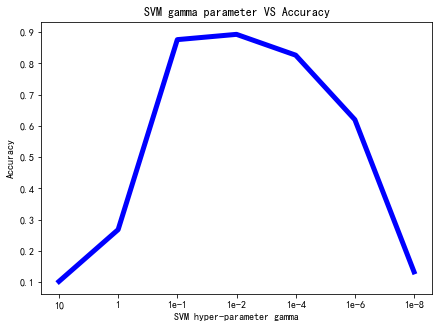

In [42]:
plt.figure(figsize = (7,5))
plt.plot(["10","1","1e-1","1e-2","1e-4","1e-6","1e-8"],AccuracyList2,"b",linewidth=5)
plt.xlabel("SVM hyper-parameter gamma")
plt.ylabel("Accuracy")
plt.title("SVM gamma parameter VS Accuracy")
plt.show()

# Hardware and software specifications of the computer

Software: Jupyter notebook; Python3

Processor : Intel Core i5 10400 2.9Ghz

RAM: 16GB 2667Mhz

GPU: NVIDIA RTX2060 6G